## Modelo lineal

> **Objetivo:** Entrenar una **Regresión Lineal** en **pipeline** (con escalado), usando **validación cruzada (≥5 folds)** y reportar **MAE, MSE, RMSE, R²** como **media ± desviación estándar**, sin fuga de datos.

### 1) Preparación

In [46]:
# Reproducibilidad y librerías
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

In [47]:
# Confirmar carga de datos
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
df = pd.read_csv('parkinsons+telemonitoring/parkinsons_updrs.data')
display(df.head())
display(df.info())

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject#       5875 non-null   int64  
 1   age            5875 non-null   int64  
 2   sex            5875 non-null   int64  
 3   test_time      5875 non-null   float64
 4   motor_UPDRS    5875 non-null   float64
 5   total_UPDRS    5875 non-null   float64
 6   Jitter(%)      5875 non-null   float64
 7   Jitter(Abs)    5875 non-null   float64
 8   Jitter:RAP     5875 non-null   float64
 9   Jitter:PPQ5    5875 non-null   float64
 10  Jitter:DDP     5875 non-null   float64
 11  Shimmer        5875 non-null   float64
 12  Shimmer(dB)    5875 non-null   float64
 13  Shimmer:APQ3   5875 non-null   float64
 14  Shimmer:APQ5   5875 non-null   float64
 15  Shimmer:APQ11  5875 non-null   float64
 16  Shimmer:DDA    5875 non-null   float64
 17  NHR            5875 non-null   float64
 18  HNR     

None

### 2) Preprocesamiento
Validación de nulos y y tipos

In [48]:
# Asegurase de uq el avariable objetivo existe y esta completa
assert 'total_UPDRS' in df.columns, "No se encontró la columna 'total_UPDRS' en el dataset."

# Confirmación de filas y columnas
print('Filas x columnas:', df.shape)

# Confirmacion de nulos
print('\nNulos por columna:')
print(df.isna().sum())

Filas x columnas: (5875, 22)

Nulos por columna:
subject#         0
age              0
sex              0
test_time        0
motor_UPDRS      0
total_UPDRS      0
Jitter(%)        0
Jitter(Abs)      0
Jitter:RAP       0
Jitter:PPQ5      0
Jitter:DDP       0
Shimmer          0
Shimmer(dB)      0
Shimmer:APQ3     0
Shimmer:APQ5     0
Shimmer:APQ11    0
Shimmer:DDA      0
NHR              0
HNR              0
RPDE             0
DFA              0
PPE              0
dtype: int64


#### Definir las caracteristicas y el objetivo

In [49]:
# Características
# Esto esta aqui por que se va a utilizar en la selección de características
FEATURES = [
    'age', 'test_time',
    'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
    'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA',
    'NHR', 'HNR', 'RPDE', 'DFA', 'PPE',
    'sex'
]

# Verificar columnas faltantes
missing = [c for c in FEATURES + ['total_UPDRS'] if c not in df.columns]
assert not missing, f"Faltan columnas en el dataset: {missing}"

X = df[FEATURES].copy()
y = df['total_UPDRS'].astype(float).copy()

### Exploracion de datos

#### Distribución de variables

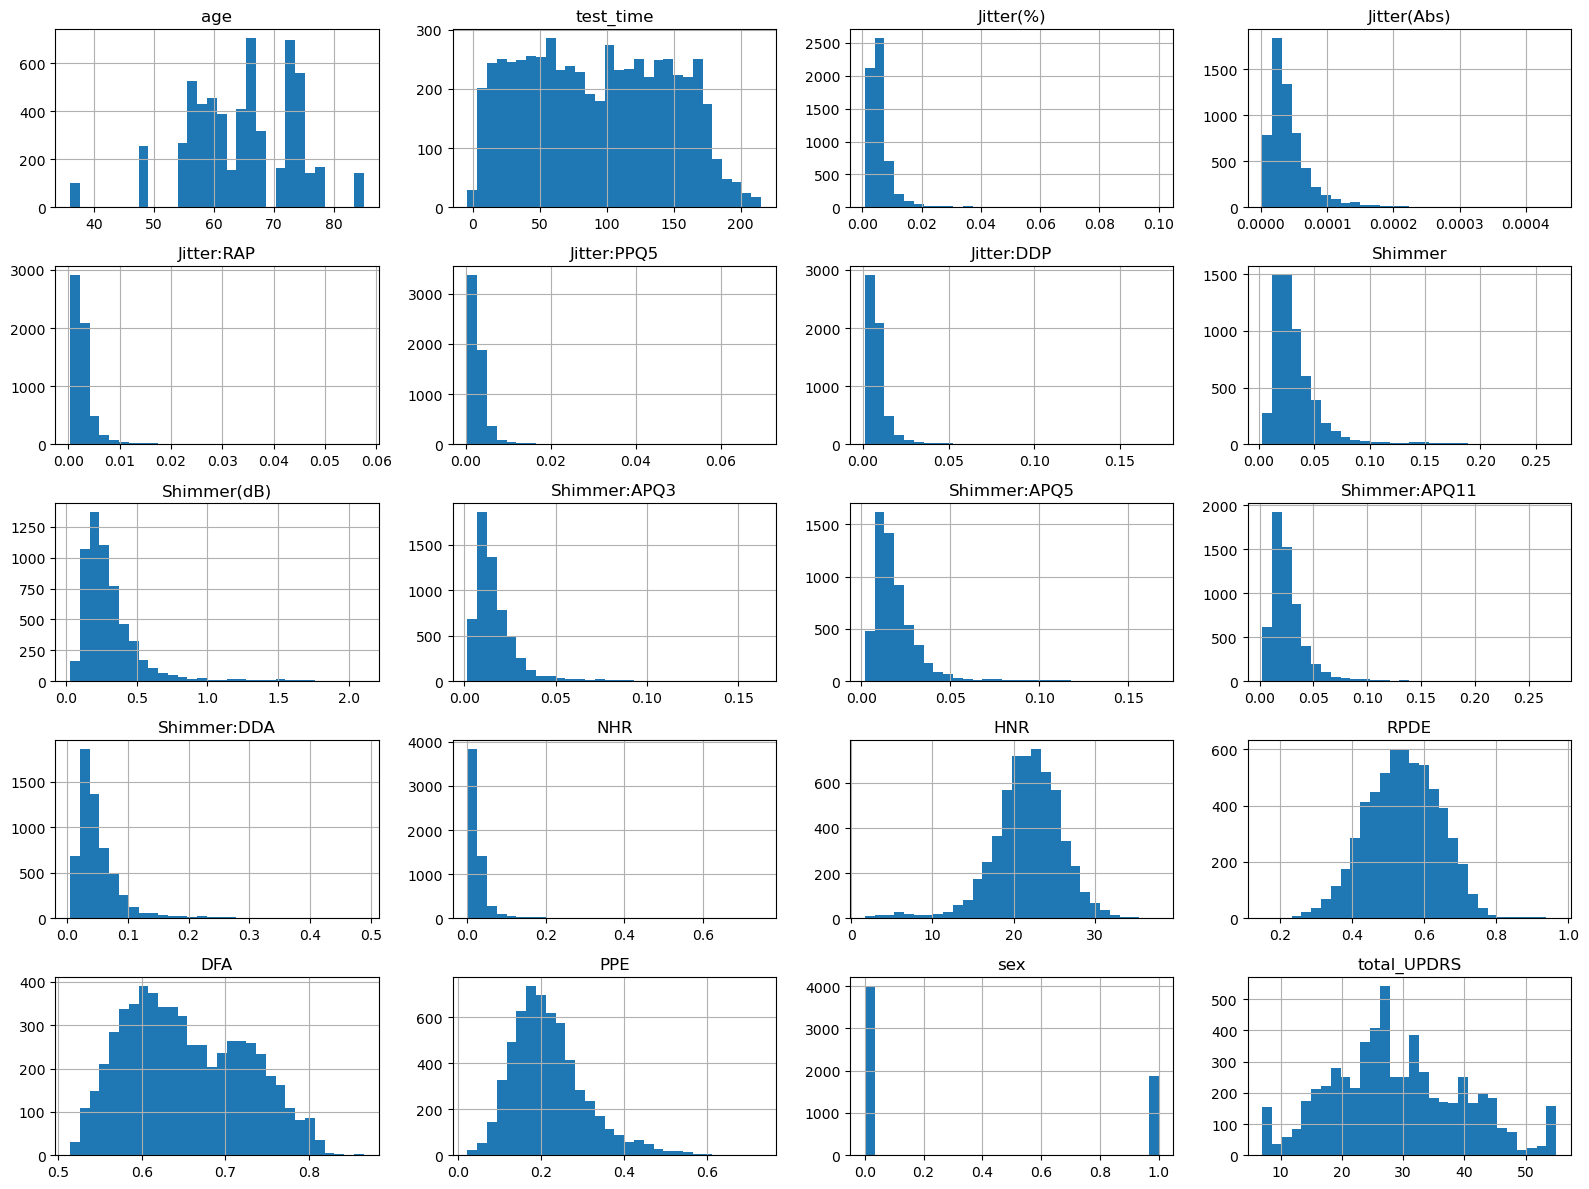

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograma de cada variable
df[FEATURES + ['total_UPDRS']].hist(bins=30, figsize=(16, 12))
plt.tight_layout()
plt.show()

#### Correlaciones

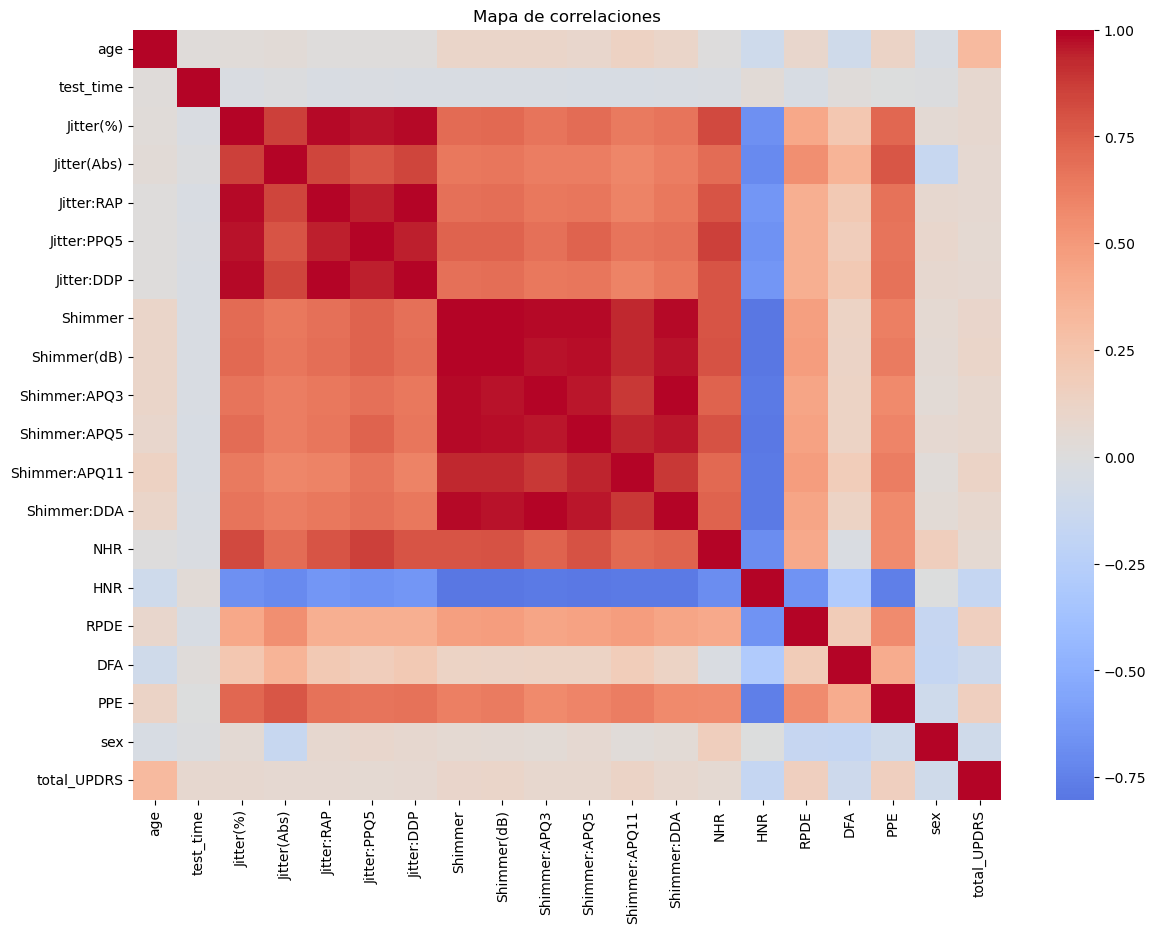

total_UPDRS      1.000000
age              0.310290
RPDE             0.156897
PPE              0.156195
Shimmer:APQ11    0.120838
Shimmer(dB)      0.098790
Shimmer          0.092141
Shimmer:APQ5     0.083467
Shimmer:DDA      0.079363
Shimmer:APQ3     0.079363
test_time        0.075263
Jitter(%)        0.074247
Jitter(Abs)      0.066927
Jitter:DDP       0.064027
Jitter:RAP       0.064015
Jitter:PPQ5      0.063352
NHR              0.060952
sex             -0.096559
DFA             -0.113475
HNR             -0.162117
Name: total_UPDRS, dtype: float64


In [51]:
corr = df[FEATURES + ['total_UPDRS']].corr()

plt.figure(figsize=(14,10))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title("Mapa de correlaciones")
plt.show()

# Top correlaciones con la variable objetivo
corr_target = corr['total_UPDRS'].sort_values(ascending=False)
print(corr_target)

#### Outliers
Box plots de variables seperados para visualizar mejor las graficas.
Los que son faciles de visualizar se quedan asi.

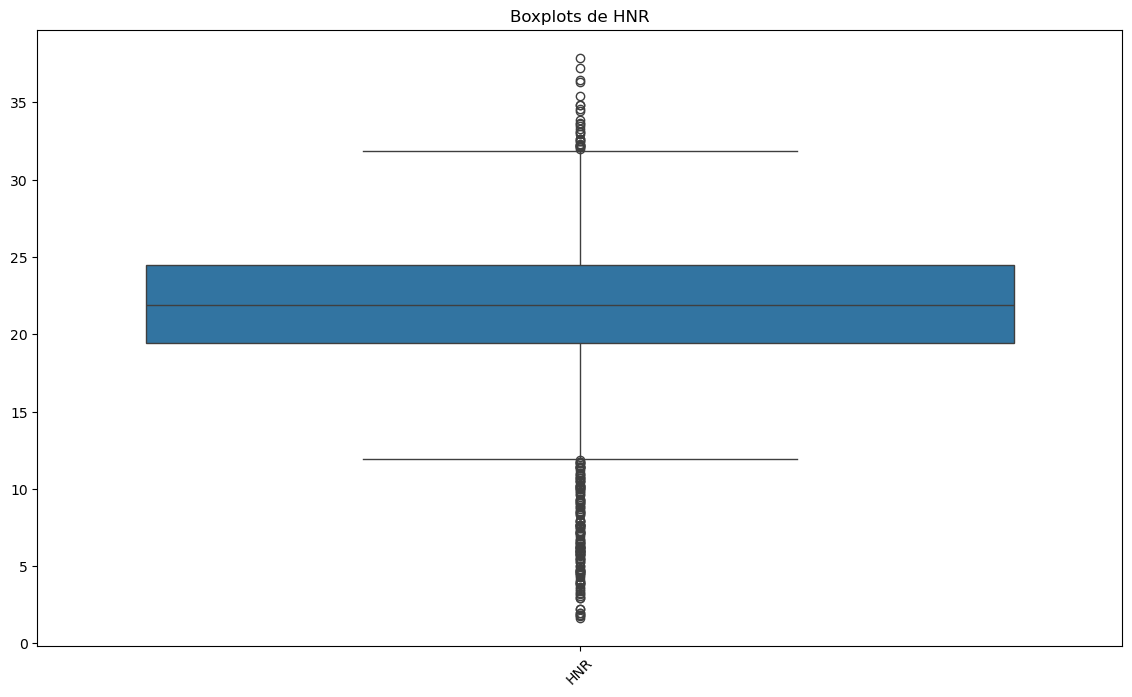

In [52]:
plt.figure(figsize=(14,8))
sns.boxplot(data=df[['HNR']])
plt.xticks(rotation=45)
plt.title("Boxplots de HNR")
plt.show()

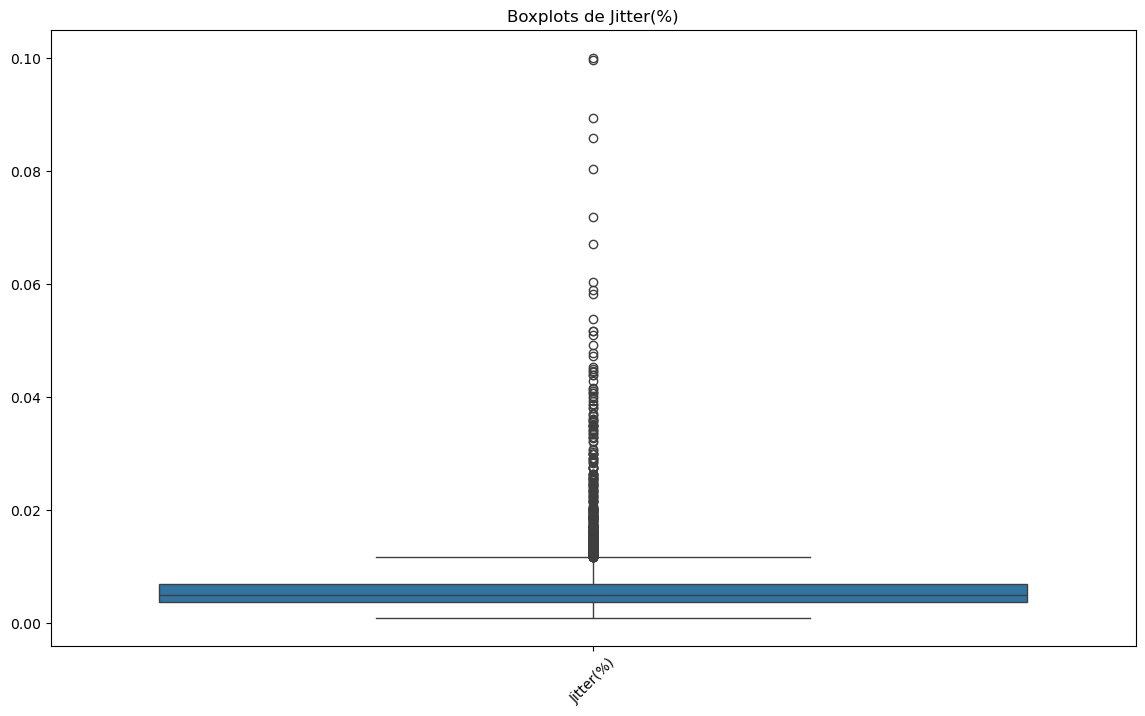

In [53]:
plt.figure(figsize=(14,8))
sns.boxplot(data=df[['Jitter(%)']])
plt.xticks(rotation=45)
plt.title("Boxplots de Jitter(%)")
plt.show()

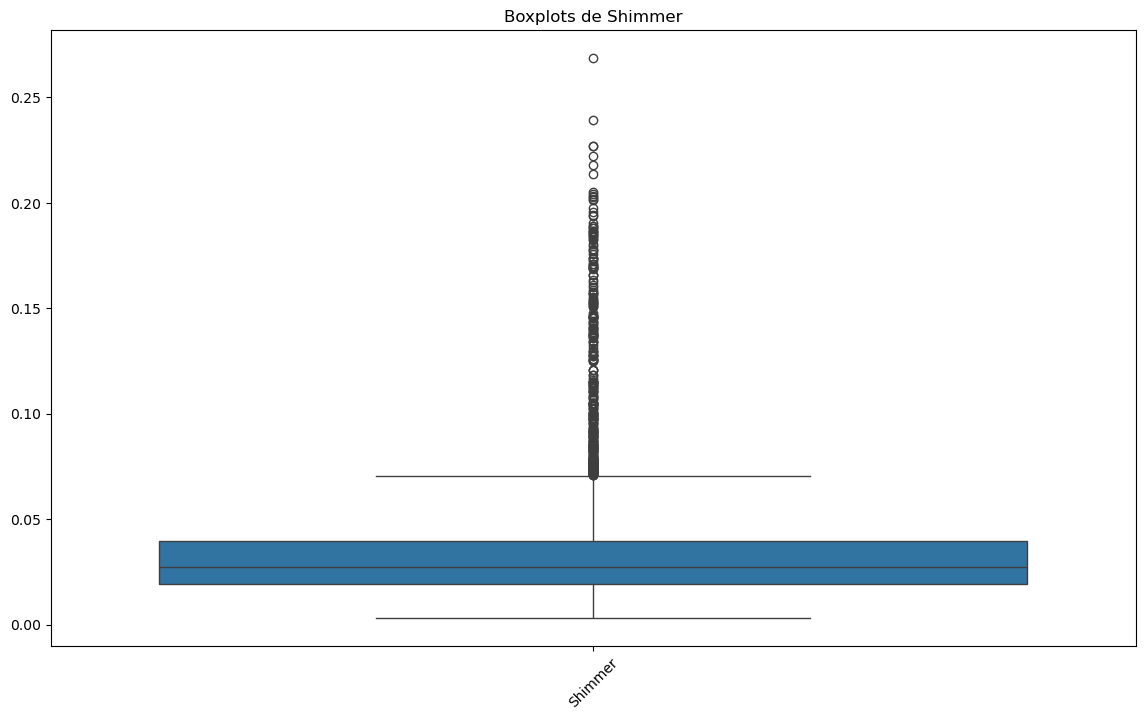

In [54]:
plt.figure(figsize=(14,8))
sns.boxplot(data=df[['Shimmer']])
plt.xticks(rotation=45)
plt.title("Boxplots de Shimmer")
plt.show()

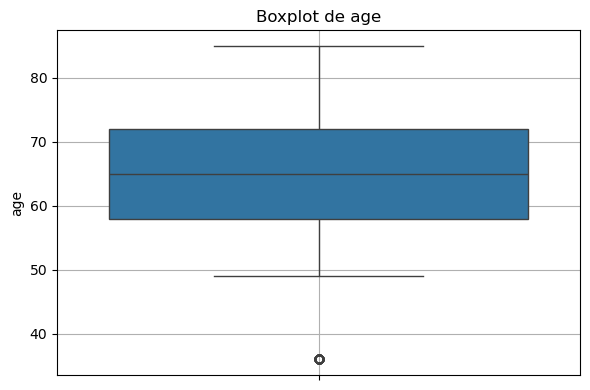

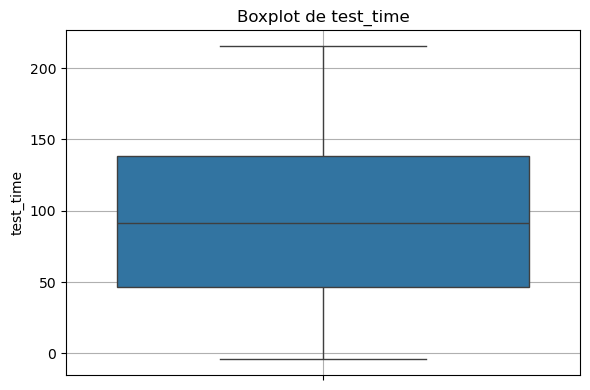

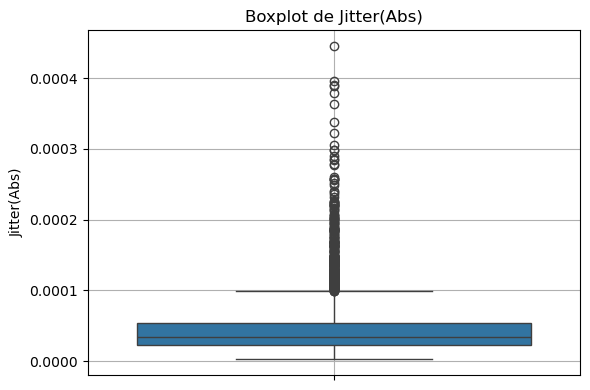

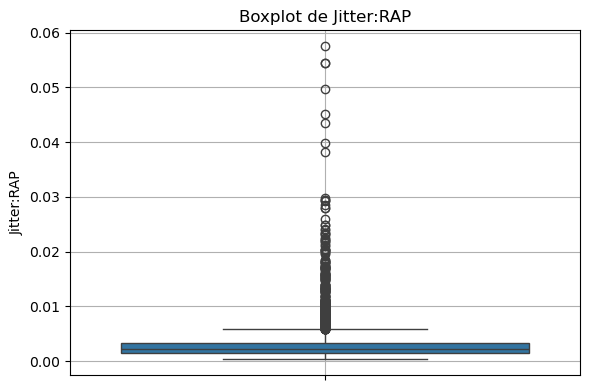

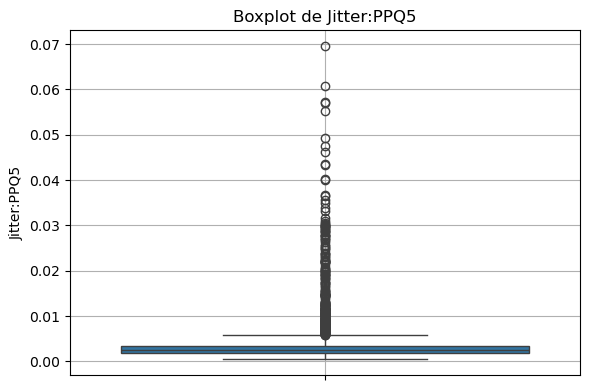

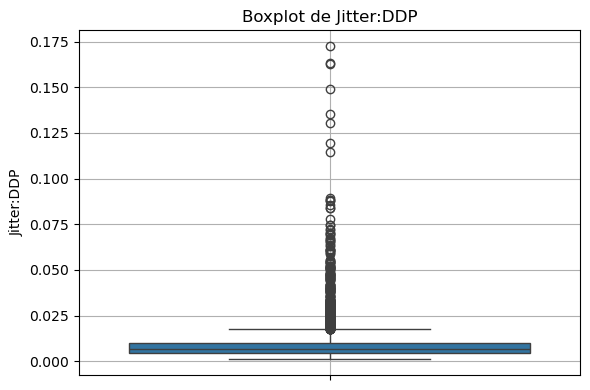

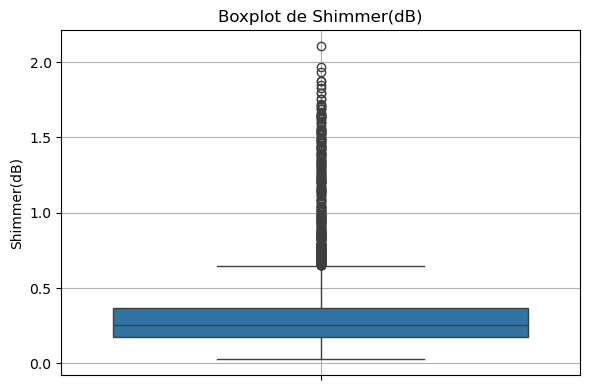

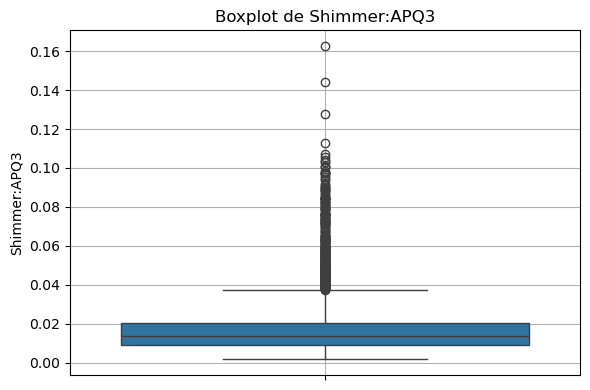

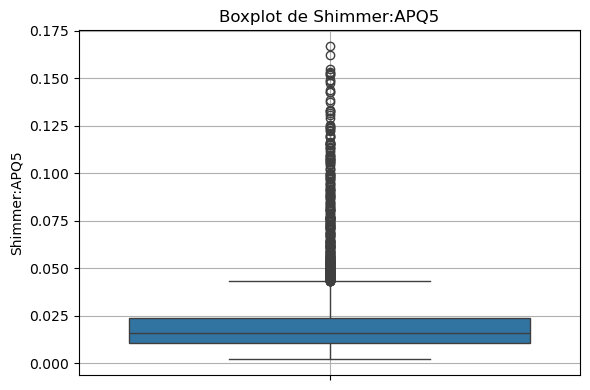

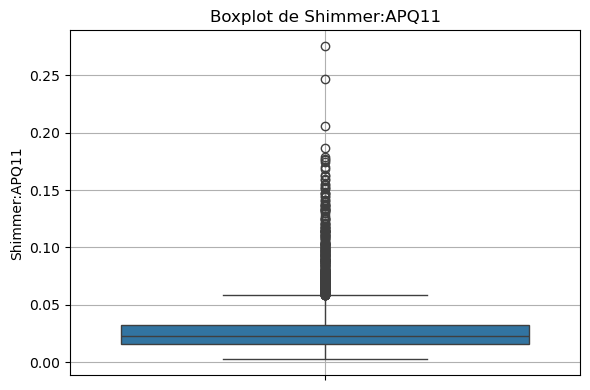

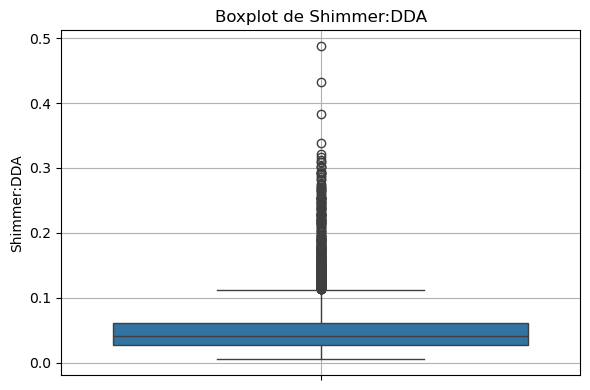

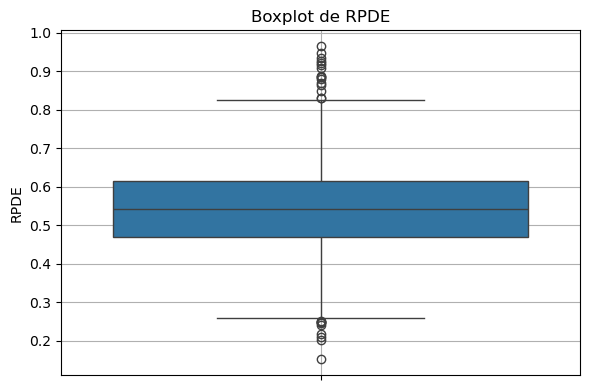

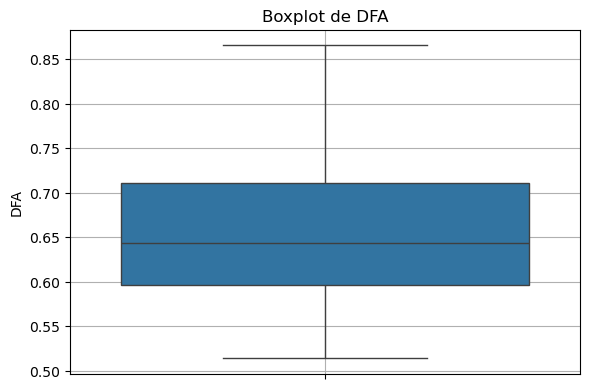

In [55]:
# Boxplots individuales para cada variable (excluyendo algunas)
exclude = ['Jitter(%)', 'Shimmer', 'NHR', 'HNR', 'PPE','sex']
for col in [c for c in FEATURES if c not in exclude]:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot de {col}")
    plt.tight_layout()
    plt.grid()
    plt.show()

### 3) Pipeline (escalado y transformaciones)

In [56]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, RobustScaler

# Variables a transformar
log_cols = [
    'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
    'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA',
    'NHR', 'PPE'
]

# Pipeline de preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('log', FunctionTransformer(np.log1p), log_cols),
        ('passthrough', 'passthrough', [c for c in FEATURES if c not in log_cols])
    ]
)

# Pipeline completo
lin_pipeline = Pipeline([
    ('pre', preprocessor),
    ('scaler', RobustScaler()),
    ('linreg', LinearRegression())
])

### 4) Validación cruzada (sin fuga) y métricas

Usamos **KFold(10)** con `shuffle=True` y `random_state` fijo.


In [57]:
# Definición de CV y métricas (scorers)
kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# Definicion de scorers
scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R2' : make_scorer(r2_score)
}

# Definicion de resultados
cv_results = cross_validate(
    lin_pipeline,
    X, y,
    cv=kf,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

# Convertimos a DataFrame para formateo
res = pd.DataFrame({
    'MAE': -cv_results['test_MAE'],  # se invierte el signo (sklearn reporta negativo por convención)
    'MSE': -cv_results['test_MSE'],
    'R2' :  cv_results['test_R2']
})
res['RMSE'] = np.sqrt(res['MSE'])

summary = res.agg(['mean','std']).T
summary.columns = ['mean','std']
summary

,mean,std
MAE,8.026360,0.287639
MSE,94.221224,6.584672
R2,0.176718,0.026906
RMSE,9.701502,0.336784


In [58]:
def fmt(mean, std):
    return f"{mean:.3f} ± {std:.3f}"

print(f"== Regresión Lineal (CV={kf.n_splits} folds) ==")
print("MAE :", fmt(summary.loc['MAE','mean'], summary.loc['MAE','std']))
print("MSE :", fmt(summary.loc['MSE','mean'], summary.loc['MSE','std']))
print("RMSE:", fmt(summary.loc['RMSE','mean'], summary.loc['RMSE','std']))
print("R²  :", fmt(summary.loc['R2','mean'],  summary.loc['R2','std']))

== Regresión Lineal (CV=10 folds) ==
MAE : 8.026 ± 0.288
MSE : 94.221 ± 6.585
RMSE: 9.702 ± 0.337
R²  : 0.177 ± 0.027


### 5) Comprobacion de modelo lineal.

> Confirma si la regresion lineal es suficiente (supera un predictor dummy)


In [59]:
baseline = DummyRegressor(strategy='median')
base_cv = cross_validate(
    baseline, X, y, cv=kf, scoring=scoring, n_jobs=-1
)
base_res = pd.DataFrame({
    'MAE': -base_cv['test_MAE'],
    'MSE': -base_cv['test_MSE'],
    'R2' :  base_cv['test_R2']
})
base_res['RMSE'] = np.sqrt(base_res['MSE'])
base_summary = base_res.agg(['mean','std']).T
base_summary.columns = ['mean','std']

print("\n== Baseline Dummy (mediana) (CV=10) ==")
print("MAE :", fmt(base_summary.loc['MAE','mean'], base_summary.loc['MAE','std']))
print("MSE :", fmt(base_summary.loc['MSE','mean'], base_summary.loc['MSE','std']))
print("RMSE:", fmt(base_summary.loc['RMSE','mean'], base_summary.loc['RMSE','std']))
print("R²  :", fmt(base_summary.loc['R2','mean'],  base_summary.loc['R2','std']))


== Baseline Dummy (mediana) (CV=10) ==
MAE : 8.582 ± 0.321
MSE : 116.595 ± 6.267
RMSE: 10.794 ± 0.293
R²  : -0.019 ± 0.009


### Resultados
Se entrenó una **Regresión Lineal** en pipeline con **StandardScaler** y se evaluó mediante **validación cruzada de 10 folds** (shuffle, `random_state=42`). Las métricas promedio (media ± std) fueron:  
- **MAE = *8.026* ± *0.288***
- **RMSE = *9.702* ± *0.337***
- **MSE = *94.221* ± *6.585***
- **R² = *0.177* ± *0.027***.  

En comparación con un **baseline Dummy (mediana)**, el modelo lineal mostró mejor desempeño en todas las metricas establecidas, lo cual sugiere que capta relaciones lineales útiles entre las variables y `total_UPDRS`.

No se realizó ninguna transformación que induzca **fuga de datos**, dado que el escalado se ejecuta **dentro del pipeline** y, por tanto, se ajusta **solo en los datos de entrenamiento** de cada fold.

### Notas

* Hay que lidiar con los outliers.
* `FEATURES` ya esta definido y va a ser utilizado en el la selección de características y la curvas.

# Selección de caracteristicas

In [60]:
# aqui el codigo para la seleccion de caracteristicas